In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import time
import pandas as pd

In [3]:
#  Set ChromeDriver path here:
driver_path = "C:/WebDriver-2/chromedriver-win64/chromedriver.exe" 

# Set your exact Flipkart product URL here:
product_url = "https://www.flipkart.com/samsung-galaxy-f05-twilight-blue-64-gb/p/itm84a914081ab93?pid=MOBH4GTXZ9ZRQ3SU&lid=LSTMOBH4GTXZ9ZRQ3SUXCBGGE&marketplace=FLIPKART&q=SAMSUNG+Galaxy+F05+%28Twilight+Blue%2C+64+GB%29++%284+GB+RAM%29&store=tyy%2F4io&spotlightTagId=default_BestsellerId_tyy%2F4io&srno=s_1_1&otracker=search&otracker1=search&fm=Search&iid=a4f135b8-3b26-4c5c-8baf-ad9515d6c95f.MOBH4GTXZ9ZRQ3SU.SEARCH&ppt=sp&ppn=sp&ssid=fppyu8xnio0000001750242614025&qH=acf4b55bf6b7808b"  # <== EDIT THIS URL

In [5]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def get_flipkart_price(product_url, driver_path):
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service)
    
    try:
        driver.get(product_url)
        time.sleep(2)
        
        try:
            close_button = driver.find_element(By.XPATH, '//button[contains(text(),"✕")]')
            close_button.click()
        except:
            pass
        
        wait = WebDriverWait(driver, 10)
        price_element = wait.until(EC.presence_of_element_located((By.XPATH, '//div[contains(@class,"Nx9bqj")]')))
        
        price_text = price_element.text
        price_numeric = int(price_text.replace('₹','').replace(',',''))
        
        print(f"[LIVE] Flipkart Price: ₹{price_numeric}")
        return price_numeric
    
    except Exception as e:
        print("Error extracting price:", e)
        return None
    
    finally:
        driver.quit()




In [7]:
flipkart_price = get_flipkart_price(product_url, driver_path)
print(f"Flipkart price fetched: ₹{flipkart_price}")

[LIVE] Flipkart Price: ₹6249
Flipkart price fetched: ₹6249


In [9]:
# 🟢  Generate 3 arm prices
arm_1 = flipkart_price - 100
arm_2 = flipkart_price - 150
arm_3 = flipkart_price - 200


# 🟢  Print arm prices
print("Flipkart live price: ₹", flipkart_price)
print("Arm 1 price (flipkart - ₹100): ₹", arm_1)
print("Arm 2 price (flipkart - ₹150): ₹", arm_2)
print("Arm 3 price (flipkart - ₹200): ₹", arm_3)

# 🟢  Save arms into list for Bandit algorithm application using E-greedy
price_arms = [arm_1, arm_2, arm_3]

Flipkart live price: ₹ 6249
Arm 1 price (flipkart - ₹100): ₹ 6149
Arm 2 price (flipkart - ₹150): ₹ 6099
Arm 3 price (flipkart - ₹200): ₹ 6049


In [11]:
# 🟢 Loading user behavior dataset for the Samsung Mobile
df_f05 = pd.read_excel('D:\Rishi\JINDAL Academics\ALP-2\GalaxyF05_UserBehavior_Dataset.xlsx')

# 🟢 Show first few rows to confirm
df_f05.head()

,UserID,ProductSKU,Num_Sessions,Total_Time_Spent(min),Avg_Session_Time(min),Viewed_Times,Added_to_Cart,Purchased,Abandoned,Device_Type,Timestamp
0,U0001,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",4,18.64,4.66,18,0,0,0,Mobile,2025-06-10
1,U0002,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",3,3.87,1.29,9,1,0,1,Desktop,2025-06-03
2,U0003,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",6,35.10,5.85,26,1,0,1,Desktop,2025-06-12
3,U0004,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",5,12.60,2.52,5,0,0,0,Desktop,2025-06-09
4,U0005,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",1,4.06,4.06,3,0,0,0,Desktop,2025-06-12


In [13]:
import random

# 🟢 Bandit parameters
epsilon = 0.1  # 10% explore, 90% exploit

# 🟢 Initialize counts and rewards for each arm
num_arms = len(price_arms)
counts = [0] * num_arms
rewards = [0] * num_arms

# 🟢 Define P(purchase) function
def compute_purchase_probability(user_row, offered_price, competitor_price):
    base_prob = 0.35
    w1 = 0.025
    w2 = 0.01
    w3 = 0.15
    w4 = 0.2
    
    price_penalty = max(0, (offered_price - competitor_price) / 1000)
    
    cart_flag = 1 if (user_row['Added_to_Cart'] == 1 or user_row['Abandoned'] == 1) else 0
    
    p = base_prob \
        + w1 * user_row['Viewed_Times'] \
        + w2 * user_row['Total_Time_Spent(min)'] \
        + w3 * cart_flag \
        - w4 * price_penalty
    
    p = max(0, min(p, 1))
    return p

# 🟢 Warm Start — pick each arm once for first N users
print("\n----- WARM START -----")
warm_start_users = num_arms  # One user per arm

for i in range(warm_start_users):
    row = df_f05.iloc[i]
    
    chosen_arm = i  # Force to pick arm 0,1,2 in order
    
    offered_price = price_arms[chosen_arm]
    p_purchase = compute_purchase_probability(row, offered_price, flipkart_price)
    reward = 1 if random.random() < p_purchase else 0
    
    counts[chosen_arm] += 1
    rewards[chosen_arm] += reward
    
    print(f"Warm start user {i+1}: Arm {chosen_arm+1} → Price ₹{offered_price} → Reward {reward}")

# 🟢 Main Bandit loop — start from user (num_arms) onwards
print("\n----- MAIN BANDIT SIMULATION -----")

for index in range(num_arms, len(df_f05)):
    row = df_f05.iloc[index]
    
    # ε-greedy: choose arm
    if random.random() < epsilon:
        chosen_arm = random.randint(0, num_arms - 1)  # Explore
    else:
        avg_rewards = [rewards[i] / counts[i] if counts[i] > 0 else 0 for i in range(num_arms)]
        chosen_arm = avg_rewards.index(max(avg_rewards))  # Exploit
    
    offered_price = price_arms[chosen_arm]
    
    p_purchase = compute_purchase_probability(row, offered_price, flipkart_price)
    reward = 1 if random.random() < p_purchase else 0
    
    counts[chosen_arm] += 1
    rewards[chosen_arm] += reward

print("\n----- FINAL BANDIT RESULTS -----")
for i, arm_price in enumerate(price_arms):
    
    total_pulls = counts[i]  # How many times this price was offered
    total_rewards = rewards[i]  # How many purchases at this price
    
    # Calculate avg reward (conversion rate)
    avg_reward = total_rewards / total_pulls if total_pulls > 0 else 0
    
    print(f"Arm {i+1}: Price ₹{arm_price} | Pulled {total_pulls} times | Purchases (rewards) = {total_rewards} | Avg Reward % = {avg_reward*100:.2f}%")



----- WARM START -----
Warm start user 1: Arm 1 → Price ₹6149 → Reward 1
Warm start user 2: Arm 2 → Price ₹6099 → Reward 1
Warm start user 3: Arm 3 → Price ₹6049 → Reward 1

----- MAIN BANDIT SIMULATION -----

----- FINAL BANDIT RESULTS -----
Arm 1: Price ₹6149 | Pulled 22 times | Purchases (rewards) = 14 | Avg Reward % = 63.64%
Arm 2: Price ₹6099 | Pulled 703 times | Purchases (rewards) = 562 | Avg Reward % = 79.94%
Arm 3: Price ₹6049 | Pulled 25 times | Purchases (rewards) = 18 | Avg Reward % = 72.00%


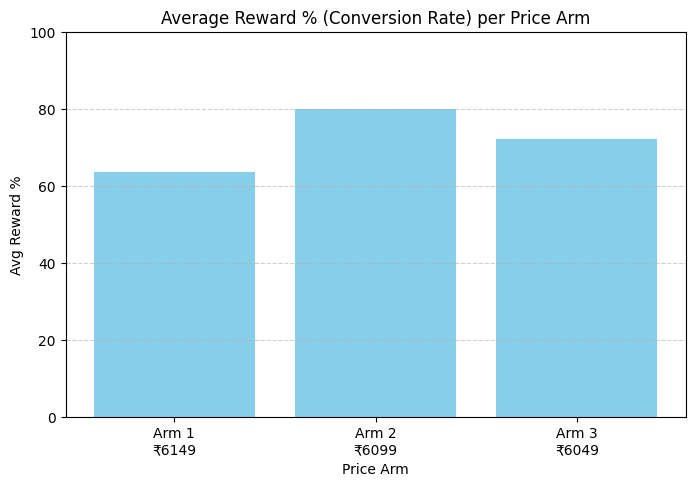

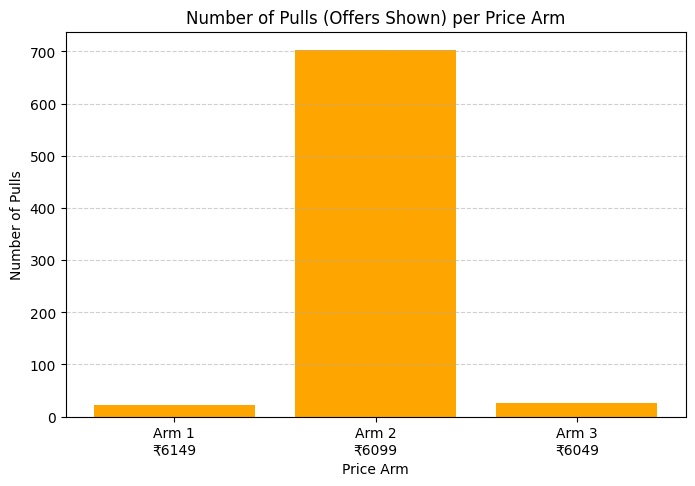

In [15]:
import matplotlib.pyplot as plt

# 🟢 Prepare data for plot
arm_labels = [f"Arm {i+1}\n₹{price_arms[i]}" for i in range(num_arms)]
total_pulls = counts
total_rewards = rewards
avg_rewards_pct = [ (rewards[i] / counts[i])*100 if counts[i]>0 else 0 for i in range(num_arms) ]

# 🟢 Plot average reward % (conversion rate)
plt.figure(figsize=(8,5))
plt.bar(arm_labels, avg_rewards_pct, color='skyblue')
plt.ylim(0,100)
plt.title('Average Reward % (Conversion Rate) per Price Arm')
plt.ylabel('Avg Reward %')
plt.xlabel('Price Arm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 🟢 Plot number of pulls per arm
plt.figure(figsize=(8,5))
plt.bar(arm_labels, total_pulls, color='orange')
plt.title('Number of Pulls (Offers Shown) per Price Arm')
plt.ylabel('Number of Pulls')
plt.xlabel('Price Arm')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [17]:
# 🟢 Calculate avg reward % for each arm
avg_rewards_pct = [ (rewards[i] / counts[i])*100 if counts[i]>0 else 0 for i in range(num_arms) ]

# 🟢 Find index of best arm
best_arm_index = avg_rewards_pct.index( max(avg_rewards_pct) )

# 🟢 Get optimal price
optimal_price = price_arms[best_arm_index]

# 🟢 Print optimal price
print(f"\n✅ Optimal Price Found: ₹{optimal_price} (Arm {best_arm_index+1}) with Avg Reward % = {avg_rewards_pct[best_arm_index]:.2f}%")



✅ Optimal Price Found: ₹6099 (Arm 2) with Avg Reward % = 79.94%


In [19]:
### Now the Rule based personalised pricing engine for leads

#Rule #	Condition	Action → Discount on Optimal Price
#1	If user Viewed_Times > 15	- ₹100 extra discount
#2	If Total_Time_Spent(min) > 10 min	- ₹150 extra discount
#3	If user Added to Cart AND Abandoned = 1	- ₹200 extra discount
#4	If user has Num_Sessions > 4	No extra discount (already engaged)
#5	If user is Mobile device	- ₹50 extra discount (targeting mobile shoppers)

#If a combination of multiple rules occur -  the highest discount only will be given so as to not over discount and affect our business

In [21]:
# A new dataset of potential leads was made to apply our Dynamic Pricing on

In [23]:
# Load your Leads dataset
df_leads = pd.read_excel('D:\Rishi\JINDAL Academics\ALP-2\GalaxyF05_UserLeads_Dataset.xlsx')

# Show first few rows to check
df_leads.head()

,UserID,ProductSKU,Num_Sessions,Total_Time_Spent(min),Avg_Session_Time(min),Viewed_Times,Added_to_Cart,Abandoned,Device_Type,Timestamp
0,Lead001,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",3,13.35,4.45,15,1,1,Mobile,2025-06-04
1,Lead002,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",2,6.10,3.05,8,1,1,Desktop,2025-06-02
2,Lead003,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",1,4.65,4.65,1,1,1,Desktop,2025-06-05
3,Lead004,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",1,4.69,4.69,1,0,0,Mobile,2025-06-05
4,Lead005,"SAMSUNG Galaxy F05 (Twilight Blue, 64 GB) (4 G...",3,9.42,3.14,7,0,0,Desktop,2025-06-02


In [25]:
# Defining the rule based fucntion whic will apply on all the rows of leads


def calculate_final_price(row, optimal_price):
    discounts = []

    # Rule 1: Viewed_Times > 15 → -₹100
    if row['Viewed_Times'] > 15:
        discounts.append(100)
    
    # Rule 2: Total_Time_Spent(min) > 10 min → -₹150
    if row['Total_Time_Spent(min)'] > 10:
        discounts.append(150)
    
    # Rule 3: Added to Cart AND Abandoned = 1 → -₹200
    if row['Added_to_Cart'] == 1 and row['Abandoned'] == 1:
        discounts.append(200)
    
    # Rule 4: Num_Sessions > 4 → No discount (business rule)
    if row['Num_Sessions'] > 4:
        discounts.append(0)
    
    # Rule 5: Mobile device → -₹50
    if row['Device_Type'] == 'Mobile':
        discounts.append(50)
    
    # Pick the highest discount
    if discounts:
        best_discount = max(discounts)
    else:
        best_discount = 0  # No rules applied
    
    # Calculate final price
    final_price = optimal_price - best_discount
    return final_price

In [27]:
# Applying this to the leads------we will get a seperate column which is the offered price for a particular lead which will
# refelect for them fro that particular  product in their account
# Apply rule-based final price per lead
df_leads['Final_Price'] = df_leads.apply(lambda row: calculate_final_price(row, optimal_price), axis=1)

# Show updated DataFrame
df_leads[['UserID', 'Viewed_Times', 'Total_Time_Spent(min)', 'Added_to_Cart', 'Abandoned', 'Device_Type', 'Final_Price']].head(10)


,UserID,Viewed_Times,Total_Time_Spent(min),Added_to_Cart,Abandoned,Device_Type,Final_Price
0,Lead001,15,13.35,1,1,Mobile,5899
1,Lead002,8,6.10,1,1,Desktop,5899
2,Lead003,1,4.65,1,1,Desktop,5899
3,Lead004,1,4.69,0,0,Mobile,6049
4,Lead005,7,9.42,0,0,Desktop,6099
5,Lead006,10,10.44,0,0,Desktop,5949
6,Lead007,10,9.66,1,1,Desktop,5899
7,Lead008,13,5.31,0,0,Desktop,6099
8,Lead009,16,22.88,1,1,Desktop,5899
9,Lead010,5,4.42,1,1,Desktop,5899


In [ ]:
# The functions:
#-----calculate_final_price----- containing the rule based final pricing
#-----compute_purchase_probability-----Purchase probability function per user
#----- get_flipkart_price-------function for scraping flipkart product price

#Are all permanently created and proven above

In [ ]:
# CODE TO KEEP THE Backend logic running and functioning as a pricing engine is given below---Every 30 minutes

# Doing a very near real-time scraping runs the risk of me getting banned by flipkart if they identify it. Hence for now 30 mins

In [ ]:
import time

while True:
    print(f"\n=== Running Dynamic Pricing Engine @ {time.strftime('%Y-%m-%d %H:%M:%S')} ===")
    
    ### 1️⃣ Scrape price
    flipkart_price = get_flipkart_price(product_url, driver_path)
    print(f"Flipkart Price: ₹{flipkart_price}")
    
    ### 2️⃣ Generate arms
    arm_1 = flipkart_price - 100
    arm_2 = flipkart_price - 150
    arm_3 = flipkart_price - 200
    price_arms = [arm_1, arm_2, arm_3]
    num_arms = len(price_arms)
    
    ### 3️⃣ Bandit Learning
    # Reset Bandit stats
    counts = [0] * num_arms
    rewards = [0] * num_arms
    
    # Warm Start
    warm_start_users = num_arms
    for i in range(warm_start_users):
        row = df_f05.iloc[i]
        chosen_arm = i
        offered_price = price_arms[chosen_arm]
        p_purchase = compute_purchase_probability(row, offered_price, flipkart_price)
        reward = 1 if random.random() < p_purchase else 0
        counts[chosen_arm] += 1
        rewards[chosen_arm] += reward
    
    # Main Bandit
    for index in range(num_arms, len(df_f05)):
        row = df_f05.iloc[index]
        
        if random.random() < epsilon:
            chosen_arm = random.randint(0, num_arms - 1)
        else:
            avg_rewards = [rewards[i] / counts[i] if counts[i] > 0 else 0 for i in range(num_arms)]
            chosen_arm = avg_rewards.index(max(avg_rewards))
        
        offered_price = price_arms[chosen_arm]
        p_purchase = compute_purchase_probability(row, offered_price, flipkart_price)
        reward = 1 if random.random() < p_purchase else 0
        counts[chosen_arm] += 1
        rewards[chosen_arm] += reward
    
    # Optimal price
    avg_rewards_pct = [ (rewards[i] / counts[i])*100 if counts[i]>0 else 0 for i in range(num_arms) ]
    best_arm_index = avg_rewards_pct.index( max(avg_rewards_pct) )
    optimal_price = price_arms[best_arm_index]
    
    print(f" Optimal Price: ₹{optimal_price} (Arm {best_arm_index+1}) | Avg Reward % = {avg_rewards_pct[best_arm_index]:.2f}%")
    
    ### 4️⃣ Load Leads
    df_leads = pd.read_excel(r'D:\Rishi\JINDAL Academics\ALP-2\GalaxyF05_UserLeads_Dataset.xlsx')
    
    ### 5️⃣ Apply Rule-based Final_Price
    df_leads['Final_Price'] = df_leads.apply(lambda row: calculate_final_price(row, optimal_price), axis=1)
    
    ### 6️⃣ Display updated Leads DataFrame (no save — just print)
    print(f"\n✅ Final_Price for Leads @ {time.strftime('%Y-%m-%d %H:%M:%S')}:")
    display(df_leads[['UserID', 'Viewed_Times', 'Total_Time_Spent(min)', 'Added_to_Cart', 'Abandoned', 'Device_Type', 'Final_Price']].head(10))
    
    
    ### 7️⃣ Wait 30 minutes
    print("Sleeping for 30 minutes...\n")
    time.sleep(1800)  # 1800 sec = 30 min
